# Media analysis


The objective of this notebook is to assess whether some medias bias the sentiment towards the USA. This means is there some medias only broadcasting positive or negative quotes about the USA. To find this out, we first need to extract the medias and then perform some statistical analyses on them. The analysis is only performed on a sample here fore runtime, but it has been performed on all the data

In [102]:
import pandas as pd 
import numpy as np
from  urllib import parse
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [103]:
df = pd.read_json("../Data - Project/quotes-2020-us.json.bz2", lines = True, compression='bz2')

### Isolating the websites  

To assess the impact of medias, we first need to find the medias in the data. There is no columns "media", but we have the url of the articles. By accessing the domain name of each article, we can find information on the media. However, the urls are in a list (all the articles where the citation occured), so the first step is to explode these lists in different rows 

In [105]:
merge = df.explode("urls")
merge.rename(columns={"urls":'url'}, inplace=True)

In [7]:
#Isolate the domain name
merge["media"] = merge["url"].apply(lambda x : "{url.netloc}".format(url = parse.urlparse(x)))

In [8]:
merge.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,phase,url,media
0,2020-03-19-002801,All immigration to the US should be halted due...,Laura Ingraham,[Q266863],2020-03-19 19:42:07,2,"[[Laura Ingraham, 0.7681], [None, 0.2254], [Me...",E,https://www.lifezette.com/2020/03/laura-ingrah...,www.lifezette.com
0,2020-03-19-002801,All immigration to the US should be halted due...,Laura Ingraham,[Q266863],2020-03-19 19:42:07,2,"[[Laura Ingraham, 0.7681], [None, 0.2254], [Me...",E,https://www.washingtonexaminer.com/news/fox-ne...,www.washingtonexaminer.com
1,2020-01-03-006209,"At the direction of the President, the U.S. mi...",Qasem Soleimani,[Q892014],2020-01-03 19:38:54,1,"[[Qasem Soleimani, 0.6097], [None, 0.368], [Ma...",E,http://www.breitbart.com/politics/2020/01/03/m...,www.breitbart.com
2,2020-03-09-006179,"Australians have always liked close, high-spee...",None,[],2020-03-09 23:00:00,1,"[[None, 0.9157], [Albert Park, 0.0843]]",E,http://goulburnpost.com.au/story/6670037/willm...,goulburnpost.com.au
3,2020-02-05-010601,"best week [ US President ] Trump has had, poli...",Greg Sheridan,[Q5606248],2020-02-05 08:31:35,1,"[[Greg Sheridan, 0.8975], [None, 0.1025]]",E,http://www.skynews.com.au/details/_6129694652001,www.skynews.com.au


### Analysing the medias  

Now that we have the media, it is interesting to have some information about it. The first thing to know is how many different medias there is

In [9]:
merge.media.nunique() 

5517

There are 5517 different medias. This is a lot, it could be interesting to look at the most common ones

In [10]:
medias = merge.groupby("media").size()

In [11]:
medias = medias.sort_values(ascending = False)

medias.head(30)

media
uspolitics.einnews.com        6364
www.news965.com               2622
www.breitbart.com             2353
www.msn.com                   2315
www.wokv.com                  2269
brazilbusiness.einnews.com    1668
msn.com                       1447
www.timesofisrael.com         1380
tass.com                      1333
www.washingtontimes.com       1246
www.wsbradio.com              1199
www.rawstory.com              1153
www.washingtonexaminer.com    1075
hypervocal.com                1072
thehill.com                   1051
www.nbcnews.com               1042
feeds.cbsnews.com              985
newsok.com                     981
www.foxnews.com                965
wtmj.com                       944
kvia.com                       942
www.krmg.com                   907
www.deccanherald.com           850
www.nytimes.com                848
www.nhregister.com             804
www.theepochtimes.com          777
abc17news.com                  763
www.thehour.com                753
stamfordadvoca

These are the most common ones. They are interesting, some familiar names like foxnews and nytimes are here, but not only. We can assume they are enough to pursue our bias analysis

In [12]:
merge = merge[merge["media"].isin(medias.nlargest(30).index)]


41602

## Sentiment per media 

Now that we have our interesting subset, we need to do the bias analysis, the first step is adding the sentiment to all the quotes

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kirsch\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
sia = SentimentIntensityAnalyzer()
# predict the sentiment of each quotation in the range [-1, 1]
merge["sentiment"] = merge.quotation.apply(lambda x: sia.polarity_scores(x)["compound"])
merge.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,phase,url,media,sentiment
53229,2020-01-08-076772,The United States will continue to follow this...,Mike Pompeo,[Q473239],2020-01-08 17:46:00,379,"[[Mike Pompeo, 0.6815], [None, 0.3179], [`` Th...",E,https://www.news965.com/news/man-arrested-afte...,www.news965.com,0.5719
9966,2020-02-06-108023,traditionally does not consider itself entitle...,None,[],2020-02-06 18:09:01,71,"[[None, 0.7815], [Recep Tayyip Erdogan, 0.073]...",E,https://tass.com/economy/1117801,tass.com,0.2467
26838,2020-01-02-020549,I hate the Trump comparisons because Brazil is...,Olavo de Carvalho,[Q729048],2020-01-02 10:05:30,170,"[[Olavo de Carvalho, 0.5959], [None, 0.3701], ...",E,http://brazilbusiness.einnews.com/article/5061...,brazilbusiness.einnews.com,0.8402
10273,2020-02-16-037874,The 15 cases have been isolated. You're not go...,Marc Siegel,[Q16210416],2020-02-16 00:00:00,1,"[[Marc Siegel, 0.715], [None, 0.285]]",E,https://www.foxnews.com/media/dr-marc-siegel-c...,www.foxnews.com,-0.4494
39319,2020-02-06-108836,"undermined our democratic institutions, making...",Zoe Lofgren,[Q218217],2020-02-06 12:17:55,2,"[[Zoe Lofgren, 0.7597], [None, 0.2403]]",E,http://www.breitbart.com/news/yovanovitch-says...,www.breitbart.com,0.4295


In [61]:
merge1 = merge[merge["media"].isin(medias.nlargest(25).index)]

#Get sentiment of top 30 medias
media_sentiment = merge1.groupby("media")["sentiment"].mean()
media_sentiment

media
brazilbusiness.einnews.com    0.428117
feeds.cbsnews.com             0.096391
hypervocal.com                0.183183
kvia.com                      0.218628
msn.com                       0.133030
newsok.com                    0.288327
tass.com                      0.157565
thehill.com                   0.191477
uspolitics.einnews.com        0.204984
wtmj.com                      0.181558
www.breitbart.com             0.141898
www.deccanherald.com          0.189604
www.foxnews.com               0.165424
www.krmg.com                 -0.078214
www.msn.com                   0.167281
www.nbcnews.com               0.177351
www.news965.com               0.144127
www.nhregister.com            0.211891
www.nytimes.com               0.248611
www.rawstory.com              0.022956
www.timesofisrael.com         0.076766
www.washingtonexaminer.com    0.152103
www.washingtontimes.com       0.211978
www.wokv.com                  0.101577
www.wsbradio.com              0.250972
Name: sentiment, dt

We can see some variation, but most fall quite close to 0. Plotting these values would give more insight


Text(0.5, 1.0, 'Mean sentiment analysis per media')

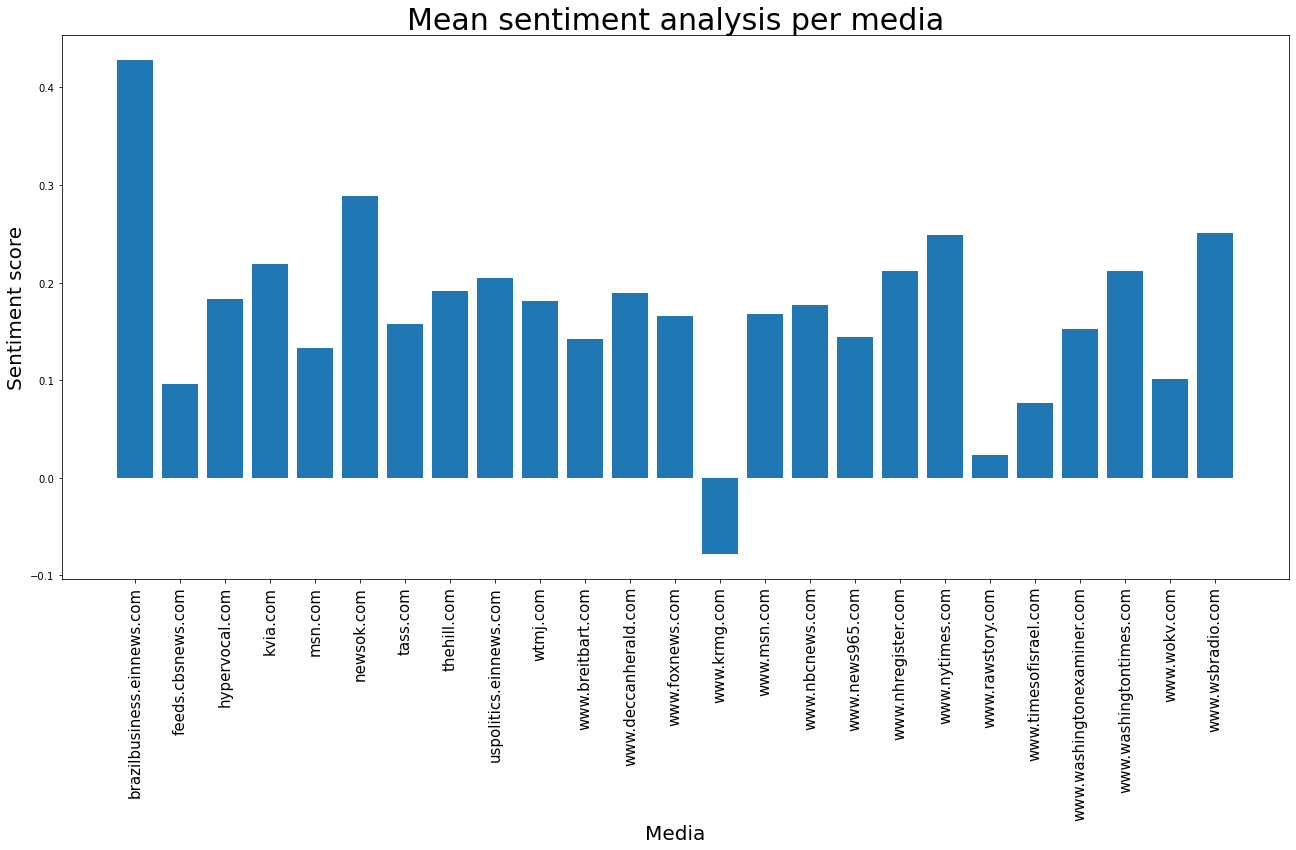

In [75]:
#Plot the mean scores per media
merge1 = merge[merge["media"].isin(medias.nlargest(25).index)]

fig_dims = (22, 10)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xticks(rotation=90, size = 15)
plt.bar(media_sentiment.index, media_sentiment)
plt.xlabel("Media",size = 20)
plt.ylabel("Sentiment score", size = 20)
plt.title("Mean sentiment analysis per media", size = 30)

Most seem to be between 0.2 and 0.4, but seems to an extreme value for einnews. To see if they are common, it is interesting to compare the distribution of all medias. To do so we compute a p-value matrix

In [36]:
#Perform a p-value on the t-test to see if the two sample come from the same distribution
t = []
for i in range(len(a)) : 
    for j in range(len(a)) : 
        wokv = merge[merge["media"] == a[i]]
        einews = merge[merge["media"] == a[j]]
        _, p_value = ttest_ind(einews.sentiment,wokv.sentiment,
                        alternative='two-sided')
        t.append(p_value)

len(t)



900

Given the potential outlier, it is interesting to look at its distribution compared to the others and also compare all distributions

In [80]:
df = pd.DataFrame(list(zip(r, b, t)),
               columns =['Media A', 'Media B', 'p-value'])

df.head()

for i in range(len(df)): 
    if df.iloc[i,-1] < 0.05 : 
        df.iloc[i,-1] = 0
    else : 
        df.iloc[i,-1] = 1
        
m = df.pivot(index='Media A', columns='Media B', values='p-value')


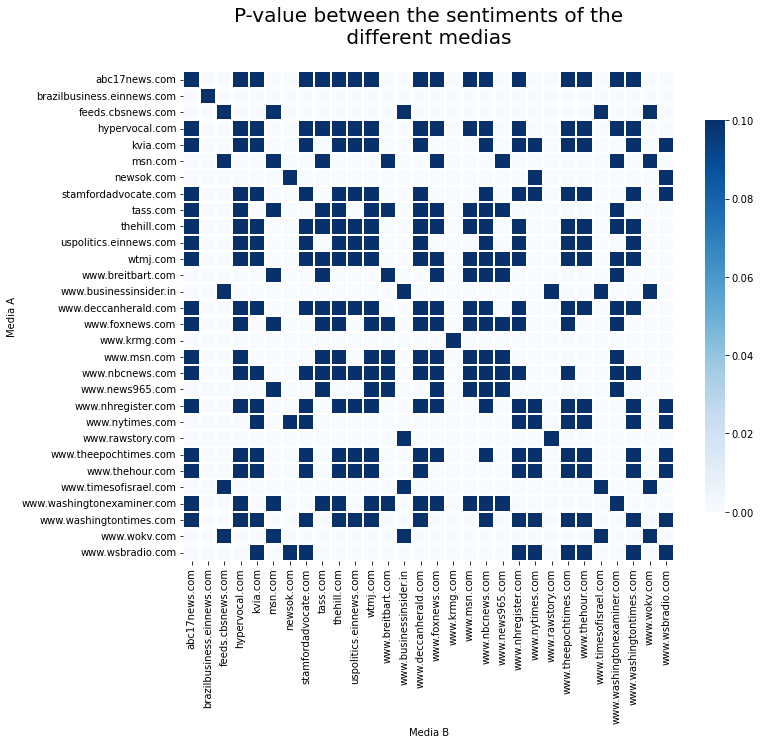

In [82]:
fig, ax = plt.subplots(figsize=(11, 9))
# plot heatmap
sns.heatmap(m, cmap="Blues", vmin= 0, vmax=0.10,
           linewidth=0.3, cbar_kws={"shrink": .8})
plt.title("P-value between the sentiments of the\n different medias \n", size = 20)
plt.show()

As the null hypothesis is rejected, there seems to be clear differences between Einnews and all the other medias. It is indeed the only media with no similar distribution to any other media

### Countries per media 

Something interesting is how the number of nationalities per media relates to its sentiment. To find this, we first need to get the nationalities from Wikidata

In [94]:
speaker_df = pd.read_parquet("../Data - Project/speaker_attributes.parquet")
speaker_df = speaker_df[['id', 'nationality']]
speaker_df.head()

,id,nationality
0,Q23,"[Q161885, Q30]"
1,Q42,[Q145]
2,Q1868,[Q31]
3,Q207,[Q30]
4,Q297,[Q29]


In [95]:
no_none = merge[merge["speaker"] != "None"]

In [96]:
no_none["speaker_id"] = no_none.qids.map(lambda x: x[0])

#join US_data with the corresponding speakers' attributes
nn_merge = pd.merge(no_none, speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
nn_merge.sample(n=5)

C:\Users\Kirsch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,phase,url,media,sentiment,speaker_id,id,nationality
20201,2020-02-01-060236,We've informed the Israeli side... that there ...,Mahmoud Abbas,"[Q10515624, Q127998, Q45193693]",2020-02-01 05:00:00,50,"[[Mahmoud Abbas, 0.6789], [None, 0.2329], [Ben...",E,https://www.rawstory.com/2020/02/palestinians-...,www.rawstory.com,0.4588,Q10515624,Q10515624,[Q801]
6683,2020-01-21-080434,The work that we've done over these past month...,Mike Pompeo,[Q473239],2020-01-21 00:37:45,2,"[[Mike Pompeo, 0.9319], [None, 0.0614], [Nicol...",E,http://www.breitbart.com/news/pompeo-reiterate...,www.breitbart.com,0.6705,Q473239,Q473239,[Q30]
13525,2020-04-06-049116,"These numbers are alarming, but firefighters a...","Camilla , Duchess of Cornwall",[Q152239],2020-04-06 08:47:00,123,"[[Camilla , Duchess of Cornwall, 0.5948], [Non...",E,https://www.wsbradio.com/news/national/pennsyl...,www.wsbradio.com,0.5346,Q152239,Q152239,[Q145]
14224,2020-03-11-002460,"Alarmingly, the president did not say how the ...",Charles Schumer,[Q380900],2020-03-11 15:06:17,191,"[[Charles Schumer, 0.4737], [Nancy Pelosi, 0.3...",E,https://www.krmg.com/weather/fox23-thursday-ov...,www.krmg.com,-0.4767,Q380900,Q380900,[Q30]
19677,2020-01-25-011150,has shown himself to be the most pro-Israel pr...,John Hagee,[Q861718],2020-01-25 00:00:00,43,"[[John Hagee, 0.8318], [None, 0.1033], [Presid...",E,http://www.thehour.com/news/article/Politics-w...,www.thehour.com,0.5809,Q861718,Q861718,[Q30]


In [100]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

                                                                                                                                                                                                            endpoint_url = "https://query.wikidata.org/sparql"

#sparkql query to get the country name and their respective quids from wikidata
query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""

'''
query internet dataset:
endpoint_url (string): url of corresponding dataset
query (string): sparksql query
'''
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

#Build a country dictionnary {quid, country name}
country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']

In [101]:
# Add nationality of speaker from the country dictionnary
merg_nation = nn_merge.explode('nationality')
merg_nation.nationality = merg_nation.nationality.map(country_dict)
merg_nation.sample(n=5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,phase,url,media,sentiment,speaker_id,id,nationality
18961,2020-02-16-011186,He thought it was -- so he thought it was very...,Arsen Avakov,"[Q2471745, Q704389]",2020-02-16 12:06:00,8,"[[Arsen Avakov, 0.5546], [None, 0.3762], [Rudy...",E,https://www.nbcnews.com/politics/trump-impeach...,www.nbcnews.com,-0.6232,Q2471745,Q2471745,Russia
7104,2020-01-08-076772,The United States will continue to follow this...,Mike Pompeo,[Q473239],2020-01-08 17:46:00,379,"[[Mike Pompeo, 0.6815], [None, 0.3179], [`` Th...",E,https://www.news965.com/news/video-hundreds-ce...,www.news965.com,0.5719,Q473239,Q473239,United States of America
23879,2020-01-03-061712,The US and Iran have been engaged in a dangero...,Abu Bakr al-Baghdadi,[Q2821724],2020-01-03 07:40:04,7,"[[Abu Bakr al-Baghdadi, 0.3857], [None, 0.3071...",E,https://kvia.com/news/us-world/2020/01/03/us-s...,kvia.com,-0.0516,Q2821724,Q2821724,NaN
11111,2020-02-22-017122,implausibly alleges that the submission of thr...,Devin Nunes,[Q539493],2020-02-22 21:21:47,1,"[[Devin Nunes, 0.6301], [None, 0.3699]]",E,https://www.washingtonexaminer.com/news/devin-...,www.washingtonexaminer.com,-0.7269,Q539493,Q539493,United States of America
3455,2020-02-04-076173,Thanks to our bold regulatory reduction campai...,President Donald Trump,[Q22686],2020-02-04 00:00:00,129,"[[President Donald Trump, 0.7151], [None, 0.17...",E,http://www.nhregister.com/news/crime/article/A...,www.nhregister.com,0.8779,Q22686,Q22686,United States of America


In [102]:
merg_nation.groupby("media")["nationality"].nunique()

media
abc17news.com                 23
brazilbusiness.einnews.com     6
feeds.cbsnews.com             16
hypervocal.com                23
kvia.com                      41
msn.com                       48
newsok.com                    27
stamfordadvocate.com          34
tass.com                      22
thehill.com                   28
uspolitics.einnews.com        16
wtmj.com                      37
www.breitbart.com             59
www.businessinsider.in        19
www.deccanherald.com          24
www.foxnews.com               26
www.krmg.com                  14
www.msn.com                   51
www.nbcnews.com               26
www.news965.com               15
www.nhregister.com            39
www.nytimes.com               28
www.rawstory.com              22
www.theepochtimes.com         27
www.thehour.com               38
www.timesofisrael.com         23
www.washingtonexaminer.com    28
www.washingtontimes.com       46
www.wokv.com                  19
www.wsbradio.com              16
Name

We can now plot number of nationality against sentiment score

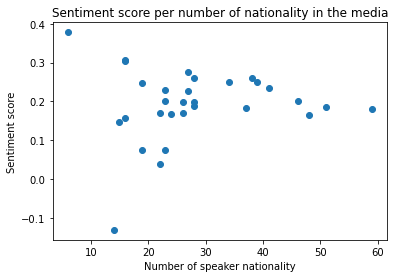

In [109]:
plt.title("Sentiment score per number of nationality in the media")
plt.ylabel("Sentiment score")
plt.xlabel("Number of speaker nationality")
plt.scatter(merg_nation.groupby("media")["nationality"].nunique(),merg_nation.groupby("media")["sentiment"].mean())

Extreme values come from low number of countries 